In [22]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
data=pd.read_excel('/content/Airlines+Data.xlsx')

<Axes: >

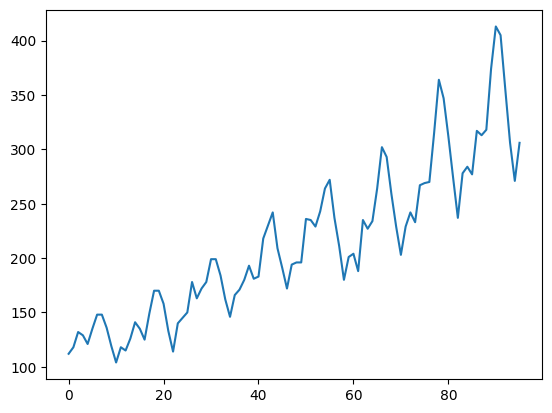

In [3]:
data.Passengers.plot()

In [4]:
data.rename(columns = {'Month':'Date'}, inplace = True)

In [5]:
data.head()

,Date,Passengers
0,1995-01-01,112
1,1995-02-01,118
2,1995-03-01,132
3,1995-04-01,129
4,1995-05-01,121


In [6]:
data.tail()

,Date,Passengers
91,2002-08-01,405
92,2002-09-01,355
93,2002-10-01,306
94,2002-11-01,271
95,2002-12-01,306


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96 entries, 0 to 95
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Date        96 non-null     datetime64[ns]
 1   Passengers  96 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.6 KB


In [8]:
data.describe()

,Passengers
count,96.000000
mean,213.708333
std,71.918216
min,104.000000
25%,156.000000
50%,200.000000
75%,264.750000
max,413.000000


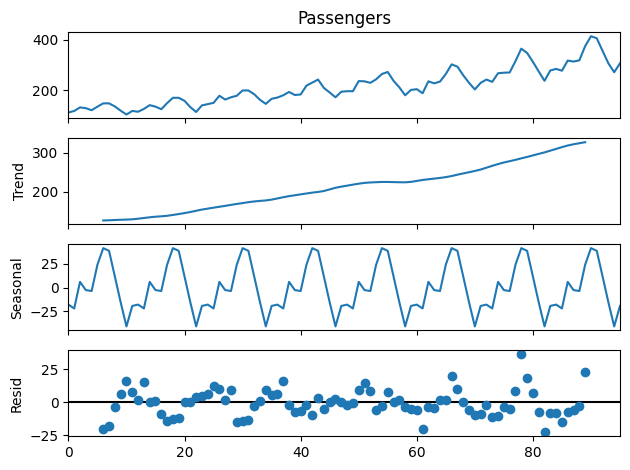

In [12]:
decompose_ts_add = seasonal_decompose(data.Passengers,period= 12)
decompose_ts_add.plot()
plt.show()

In [16]:
data['Date'] = pd.to_datetime(data['Date'])
data['Months'] = data['Date'].dt.strftime('%b')
data["year"] = data['Date'].dt.strftime("%Y")
data.head()

,Date,Passengers,Months,year
0,1995-01-01,112,Jan,1995
1,1995-02-01,118,Feb,1995
2,1995-03-01,132,Mar,1995
3,1995-04-01,129,Apr,1995
4,1995-05-01,121,May,1995


<Axes: xlabel='Months', ylabel='year'>

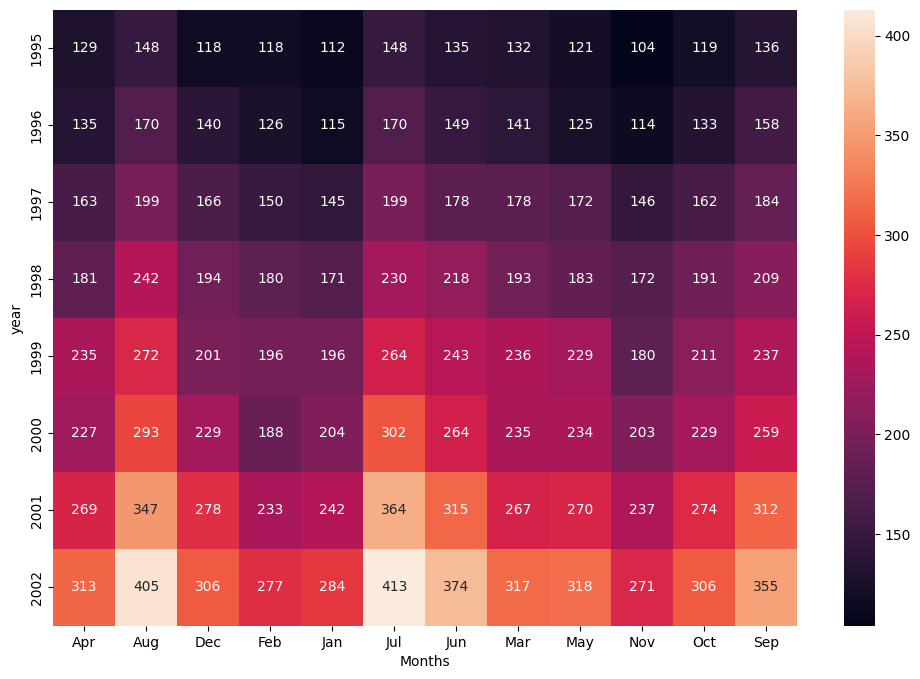

In [17]:
plt.figure(figsize=(12,8))
heatmap_y_month = pd.pivot_table(data=data,values="Passengers",index="year",columns="Months",fill_value=0)
sns.heatmap(heatmap_y_month,annot=True,fmt="g")

<Axes: xlabel='year', ylabel='Passengers'>

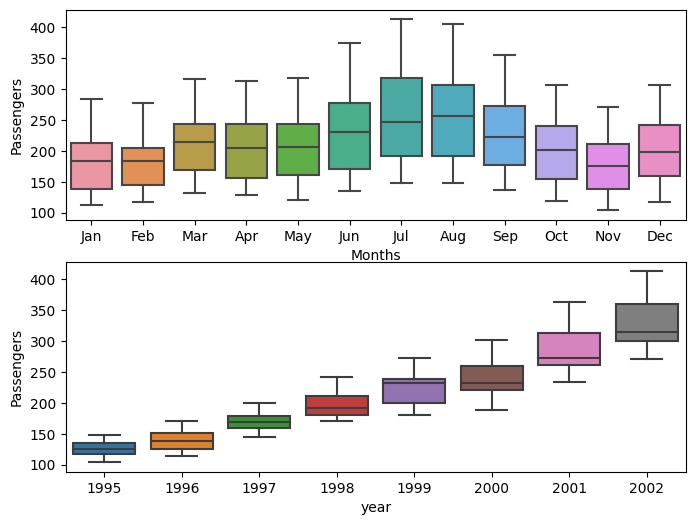

In [19]:
plt.figure(figsize=(8,6))
plt.subplot(211)
sns.boxplot(x="Months",y="Passengers",data=data)
plt.subplot(212)
sns.boxplot(x="year",y="Passengers",data=data)

<Axes: xlabel='year', ylabel='Passengers'>

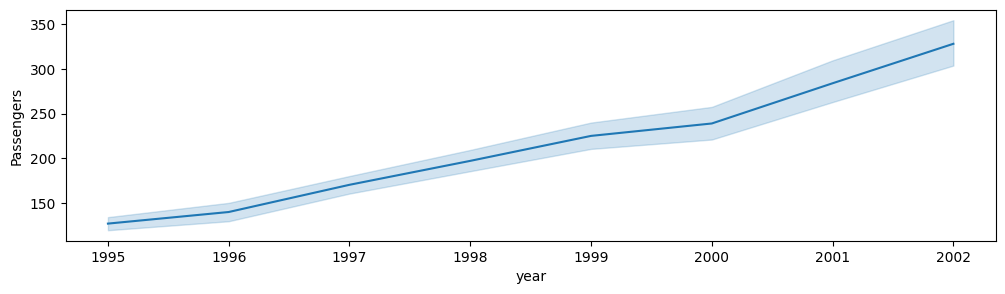

In [20]:
plt.figure(figsize=(12,3))
sns.lineplot(x="year",y="Passengers",data=data)

In [21]:
month_dummies = pd.DataFrame(pd.get_dummies(data['Months']))
data1 = pd.concat([data,month_dummies],axis = 1)
data1.head()

,Date,Passengers,Months,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep
0,1995-01-01,112,Jan,1995,0,0,0,0,1,0,0,0,0,0,0,0
1,1995-02-01,118,Feb,1995,0,0,0,1,0,0,0,0,0,0,0,0
2,1995-03-01,132,Mar,1995,0,0,0,0,0,0,0,1,0,0,0,0
3,1995-04-01,129,Apr,1995,1,0,0,0,0,0,0,0,0,0,0,0
4,1995-05-01,121,May,1995,0,0,0,0,0,0,0,0,1,0,0,0


In [24]:
data1["t"] = np.arange(1,97)
data1["t_squared"] = data1["t"]*data1["t"]
data1["log_Passengers"] = np.log(data1["Passengers"])
data1.columns
data1.head()

,Date,Passengers,Months,year,Apr,Aug,Dec,Feb,Jan,Jul,Jun,Mar,May,Nov,Oct,Sep,t,t_squared,log_Passengers
0,1995-01-01,112,Jan,1995,0,0,0,0,1,0,0,0,0,0,0,0,1,1,4.718499
1,1995-02-01,118,Feb,1995,0,0,0,1,0,0,0,0,0,0,0,0,2,4,4.770685
2,1995-03-01,132,Mar,1995,0,0,0,0,0,0,0,1,0,0,0,0,3,9,4.882802
3,1995-04-01,129,Apr,1995,1,0,0,0,0,0,0,0,0,0,0,0,4,16,4.859812
4,1995-05-01,121,May,1995,0,0,0,0,0,0,0,0,1,0,0,0,5,25,4.795791


In [26]:
Train = data1.head(75)
Test = data1.tail(25)

In [27]:
#Linear Model
import statsmodels.formula.api as smf

linear_model = smf.ols('Passengers~t',data=Train).fit()
pred_linear =  pd.Series(linear_model.predict(pd.DataFrame(Test['t'])))
rmse_linear = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_linear))**2))
rmse_linear

51.83809749584509

In [28]:
#Exponential

Exp = smf.ols('log_Passengers~t',data=Train).fit()
pred_Exp = pd.Series(Exp.predict(pd.DataFrame(Test['t'])))
rmse_Exp = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Exp)))**2))
rmse_Exp

42.77525975019796

In [30]:
#Quadratic

Quad = smf.ols('Passengers~t+t_squared',data=Train).fit()
pred_Quad = pd.Series(Quad.predict(Test[["t","t_squared"]]))
rmse_Quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_Quad))**2))
rmse_Quad

54.031406456252654

In [31]:
#Additive seasonality

add_sea = smf.ols('Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea = pd.Series(add_sea.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov']]))
rmse_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea))**2))
rmse_add_sea

123.02763788084248

In [32]:
#Additive Seasonality Quadratic

add_sea_Quad = smf.ols('Passengers~t+t_squared+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data=Train).fit()
pred_add_sea_quad = pd.Series(add_sea_Quad.predict(Test[['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','t','t_squared']]))
rmse_add_sea_quad = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(pred_add_sea_quad))**2))
rmse_add_sea_quad

36.53627444546955

In [33]:
#Multiplicative Seasonality

Mul_sea = smf.ols('log_Passengers~Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_sea = pd.Series(Mul_sea.predict(Test))
rmse_Mult_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_sea)))**2))
rmse_Mult_sea

128.166228175962

In [34]:
#Multiplicative Additive Seasonality

Mul_Add_sea = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov',data = Train).fit()
pred_Mult_add_sea = pd.Series(Mul_Add_sea.predict(Test))
rmse_Mult_add_sea = np.sqrt(np.mean((np.array(Test['Passengers'])-np.array(np.exp(pred_Mult_add_sea)))**2))
rmse_Mult_add_sea

11.565825437616011

In [35]:
#Compare the results

data = {"MODEL":pd.Series(["rmse_linear","rmse_Exp","rmse_Quad","rmse_add_sea","rmse_add_sea_quad","rmse_Mult_sea","rmse_Mult_add_sea"]),"RMSE_Values":pd.Series([rmse_linear,rmse_Exp,rmse_Quad,rmse_add_sea,rmse_add_sea_quad,rmse_Mult_sea,rmse_Mult_add_sea])}
table_rmse=pd.DataFrame(data)
table_rmse.sort_values(['RMSE_Values'])

,MODEL,RMSE_Values
6,rmse_Mult_add_sea,11.565825
4,rmse_add_sea_quad,36.536274
1,rmse_Exp,42.775260
0,rmse_linear,51.838097
2,rmse_Quad,54.031406
3,rmse_add_sea,123.027638
5,rmse_Mult_sea,128.166228


PREDICTING ON TEST DATA

In [43]:
model_full = smf.ols('log_Passengers~t+Jan+Feb+Mar+Apr+May+Jun+Jul+Aug+Sep+Oct+Nov+Dec',data =data1).fit()
pred_new  = pd.Series(model_full.predict(Test))
Test["Forecasted_log"] = pd.Series(pred_new)
Test['Forecasted_Passengers'] = np.exp(Test['Forecasted_log'])

<ipython-input-43-879102a89997>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test["Forecasted_log"] = pd.Series(pred_new)
<ipython-input-43-879102a89997>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Test['Forecasted_Passengers'] = np.exp(Test['Forecasted_log'])


In [44]:
Final_predict = Test.loc[:, ['Date', 'Forecasted_Passengers']]
Final_predict

,Date,Forecasted_Passengers
71,2000-12-01,238.563822
72,2001-01-01,245.011964
73,2001-02-01,247.604220
74,2001-03-01,285.719509
75,2001-04-01,276.485462
76,2001-05-01,274.687846
77,2001-06-01,310.901926
78,2001-07-01,345.755449
79,2001-08-01,345.024404
80,2001-09-01,309.010827


In [46]:
new_var = pd.concat([Train,Final_predict])

<Axes: >

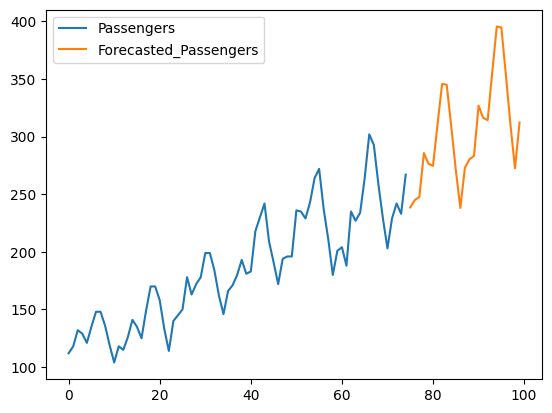

In [48]:
new_var[['Passengers','Forecasted_Passengers']].reset_index(drop=True).plot()